# Predicting ROI of Personalised Marketing Efforts

## Table of Contents

1. [Problem Statement](#1.-problem-statement)
2. [Data Source](#2.-data-source)
3. [Data Preprocessing](#3.-data-preprocessing)
4. [EDA](#4.-eda)
5. [Modelling](#5.-Modelling)
6. [Model with Improved Relational Data](#6.-Model-with-Improved-Relational-Data)
7. [Comparison of Model Performance: Independent Random Forest vs. Regressor Chain](#7-comparison-of-model-performance-independent-random-forest-vs-regressor-chain)

## 1. Problem Statement
Banks struggle to quantify the effectiveness of their marketing efforts, often resulting in suboptimal resource allocation and low returns on investment (ROI). The lack of a robust ROI measurement model makes it difficult to assess the financial impact of marketing campaigns and identify which strategies drive meaningful engagement and conversions. Without a reliable model to measure the financial impact of campaigns, it becomes difficult to evaluate which strategies drive meaningful engagement and conversions.

This project aims to develop a machine learning-based ROI model that accurately measures the financial return of personalized marketing campaigns. By leveraging customer data and analyzing factors such as campaign costs, engagement metrics, and conversion rates, the ROI model will provide a data-driven output by predicting the key performance indicators (KPIs) to maximize marketing efficiency. This model will help banks optimize resource allocation, prioritize high-impact campaigns, and ultimately improve the profitability of their marketing strategies.

The core question is: **How can we build a reliable model to measure and maximize the ROI of personalized marketing efforts in the banking sector?**

## 2. Data Source
Our group selected two Kaggle datasets to analyze and understand the impact of marketing campaigns on customer engagement and spending efficiency:

1. **[Analyze the Marketing Spending](https://www.kaggle.com/datasets/sinderpreet/analyze-the-marketing-spending):**  
   This dataset provides insights into resource allocation across various marketing campaigns. It allows us to examine how spending is distributed among different channels and measure its effectiveness in reaching and engaging customers.

2. **[Online Advertising Digital Marketing Data](https://www.kaggle.com/datasets/naniruddhan/online-advertising-digital-marketing-data):**  
   This dataset contains detailed information on digital advertising efforts, such as customer clicks, leads, and conversions. It helps us understand the specific outcomes of advertising campaigns across digital platforms, highlighting customer interactions and responses.

Together, these datasets enable a comprehensive analysis of the relationship between marketing spend and customer engagement, essential for evaluating and predicting the ROI of marketing campaigns. By identifying patterns of high-return campaign, we can leverage these insights to develop a robust ROI model, enhancing data-driven marketing decisions.


In [1]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('Marketing.csv')
df2 = pd.read_csv('archive/online_advertising_performance_data.csv')

## 3. Data Preprocessing
### 3.1 Data cleaning for [Dataset 1](https://www.kaggle.com/datasets/sinderpreet/analyze-the-marketing-spending)

1. **Checking for Missing Values and Data Types:**  
   We start by examining the dataset's structure and data types using `df1.info()`. This provides a preliminary overview of any columns with missing values or incorrect data types that might require adjustments.

2. **Removing Duplicates:**  
   Duplicate rows can lead to biased analysis, so we remove them using `df1.drop_duplicates(inplace=True)` to ensure data quality and accuracy in subsequent calculations.

3. **Handling Missing Values:**  
   After identifying columns with missing values via `df1.isnull().sum()`, we remove rows with missing data using `df1.dropna()` to maintain a complete dataset for reliable analysis. This step ensures that any blank fields won’t introduce inaccuracies in the model.

4. **Calculating Click-to-Revenue Conversion Rate:**  
   We calculate a new metric, `click_to_revenue_ratio`, by dividing `revenue` by `clicks`. This metric provides insight into the efficiency of ad clicks in generating revenue, helping us assess campaign performance.

5. **Removing Irrelevant Columns:**  
   To focus on relevant features, we drop columns that are not useful for modeling, such as `id`, `c_date`, `campaign_name`, and `campaign_id`, storing the cleaned dataset in `df1_cleaned`.

6. **Renaming Columns:**  
   For clarity and consistency, we rename the `mark_spent` column to `cost`. This aligns with our project's terminology, as `cost` directly represents the financial input for each campaign.

7. **Verifying the Cleaned Data:**  
   Finally, we check the first few rows of the cleaned dataset using `df1_cleaned.head()` to confirm the successful execution of each cleaning step and ensure the dataset is ready for further analysis.

This cleaning process prepares the data for accurate modeling and analysis by eliminating redundancies and focusing on key features. 


In [2]:
# Check for missing values and data types
print(df1.info())

# Drop duplicates
df1.drop_duplicates(inplace=True)

# Check for missing values
print(df1.isnull().sum())

# Drop missing values (if any)
df1 = df1.dropna()

# Calculate Click to Revenue Conversion Rate
df1['click_to_revenue_ratio'] = df1['revenue'] / df1['clicks']

df1_cleaned = df1.drop(columns=["id", "c_date", "campaign_name", "campaign_id"])
df1_cleaned = df1_cleaned.rename(columns={"mark_spent": "cost"})

# Verify cleaned data
print(df1_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             308 non-null    int64  
 1   c_date         308 non-null    object 
 2   campaign_name  308 non-null    object 
 3   category       308 non-null    object 
 4   campaign_id    308 non-null    int64  
 5   impressions    308 non-null    int64  
 6   mark_spent     308 non-null    float64
 7   clicks         308 non-null    int64  
 8   leads          308 non-null    int64  
 9   orders         308 non-null    int64  
 10  revenue        308 non-null    float64
dtypes: float64(2), int64(6), object(3)
memory usage: 26.6+ KB
None
id               0
c_date           0
campaign_name    0
category         0
campaign_id      0
impressions      0
mark_spent       0
clicks           0
leads            0
orders           0
revenue          0
dtype: int64
     category  impressions      c

### 3.2 Data Cleaning for [Dataset 2](https://www.kaggle.com/datasets/naniruddhan/online-advertising-digital-marketing-data)

1. **Identifying Missing Values:**  
   To address potential data quality issues, we start by identifying columns with missing values using `df2.isnull().sum()`. This helps us pinpoint which features may need handling or removal.

2. **Removing Empty Columns:**  
   Columns containing only NaN values do not contribute to analysis, so we drop them with `df2.dropna(axis=1, how='all')`. This action, stored in `df2_cleaned`, ensures that our dataset remains compact and relevant.

3. **Setting Up Synthetic Leads Data:**  
   Since we may lack a specific `leads` column, we create a synthetic one. We define a base conversion rate of 2.5% (`base_conversion_rate = 0.025`) as a starting point for how many clicks lead to actual conversions. Adding random noise (`conversion_adjustment = np.random.uniform(0.9, 1.1, len(df2))`) simulates real-world campaign performance variance. Multiplying `clicks` by this conversion rate and noise yields an estimated `leads` value.

4. **Dropping Unnecessary Columns:**  
   Columns that are not essential for analysis, such as `month`, `day`, `campaign_number`, `user_engagement`, and `banner`, are removed to keep our dataset streamlined and focused.

5. **Renaming Columns for Consistency:**  
   To align our dataset with project terminology, we rename:
   - `'placement'` to `'category'`
   - `'displays'` to `'impressions'`
   - `'post_click_conversions'` to `'orders'`
   - `'post_click_sales_amount'` to `'revenue'`

6. **Reformatting `category` Values for Cohesion:**  
   To standardize values within the `category` column, we make the following replacements:
   - `'abc'` is replaced with `'jkl'` in a preliminary step.
   - Next, we map specific codes to match our categories:
     - `'mno'` to `'social'`
     - `'def'` to `'search'`
     - `'ghi'` to `'influencer'`
     - `'jkl'` to `'media'`

7. **Creating Click-to-Revenue Ratio Metric:**  
   A `click_to_revenue_ratio` metric is introduced by dividing `revenue` by `clicks` for each row. This metric, calculated using `apply` with a lambda function, provides insight into revenue generation per click, aiding in ROI analysis. We handle potential division by zero by returning `0` where `clicks` equals `0`.

8. **Final Verification of Data Transformation:**  
   We display the first few rows and key columns (e.g., `revenue`, `clicks`, and `click_to_revenue_ratio`) to confirm the transformations' success and check for any irregularities in the processed dataset.

This structured preparation stage ensures our dataset is clean, relevant, and aligned with our project objectives, setting a solid foundation for further analysis and modeling.

In [3]:
# Check for missing values
print(df2.isnull().sum())

# Drop columns where all values are NaN
df2_cleaned = df2.dropna(axis=1, how='all')

# Verify the updated dataframe
print(df2_cleaned.columns)

# Define a base conversion rate (you can adjust this based on your understanding)
base_conversion_rate = 0.025  # 2.5% of clicks turn into leads

# Add random noise to simulate variance in campaign performance
conversion_adjustment = np.random.uniform(0.9, 1.1, len(df2))  # Random adjustment between 90% to 110%

# Create a synthetic 'leads' column based on clicks, budget, and random noise
df2_cleaned['leads'] = (df2_cleaned['clicks'] * base_conversion_rate * conversion_adjustment).astype(int)

# Remove the specified columns
df2_cleaned = df2_cleaned.drop(columns=["month", "day", "campaign_number", "user_engagement","banner"])

# Rename the 'placement' column to 'category'
df2_cleaned = df2_cleaned.rename(columns={"placement": "category"})
# Rename 'displays' to 'impressions'
df2_cleaned = df2_cleaned.rename(columns={"displays": "impressions"})
# Replace 'abc' with 'jkl' in the 'category' column
df2_cleaned['category'] = df2_cleaned['category'].replace('abc', 'jkl')
# Rename 'post_click_conversions' to 'orders'
df2_cleaned = df2_cleaned.rename(columns={"post_click_conversions": "orders"})

# Remove the 'revenue' column
df2_cleaned = df2_cleaned.drop(columns=["revenue"])

# Rename 'post_click_sales_amount' to 'revenue'
df2_cleaned = df2_cleaned.rename(columns={"post_click_sales_amount": "revenue"})
# Add a 'click_to_revenue_ratio' column, handling division by zero
df2_cleaned['click_to_revenue_ratio'] = df2_cleaned.apply(lambda row: row['revenue'] / row['clicks'] if row['clicks'] != 0 else 0, axis=1)

# Verify the new column
print(df2_cleaned[['revenue', 'clicks', 'click_to_revenue_ratio']].head())
# Replace category elements with new values
df2_cleaned['category'] = df2_cleaned['category'].replace({
    'mno': 'social',
    'def': 'search',
    'ghi': 'influencer',
    'jkl': 'media'
})

# Verify the changes
print(df2_cleaned['category'].value_counts())
print(df2_cleaned.head())

month                          0
day                            0
campaign_number                0
user_engagement                0
banner                         0
placement                    413
displays                       0
cost                           0
clicks                         0
revenue                        0
post_click_conversions         0
post_click_sales_amount        0
Unnamed: 12                15408
Unnamed: 13                15408
dtype: int64
Index(['month', 'day', 'campaign_number', 'user_engagement', 'banner',
       'placement', 'displays', 'cost', 'clicks', 'revenue',
       'post_click_conversions', 'post_click_sales_amount'],
      dtype='object')
      revenue  clicks  click_to_revenue_ratio
0      0.0000       0                0.000000
1   1972.4602     158               12.483925
2   2497.2636     158               15.805466
3  24625.3234    1796               13.711205
4      0.0000       1                0.000000
category
social        4501
search

/var/folders/zw/3t7l5c4d55s8jj_c6q8c681h0000gn/T/ipykernel_10700/1211675648.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_cleaned['leads'] = (df2_cleaned['clicks'] * base_conversion_rate * conversion_adjustment).astype(int)


### 3.3 Join Dataset 1 & Dataset 2

To create a robust and diverse dataset for modeling, we combine Dataset 1 and Dataset 2. Each dataset offers unique and complementary features that enhance our understanding of marketing performance and ROI. By merging these datasets, we create a more comprehensive data foundation that covers a wider range of marketing attributes and customer interactions.

1. **Purpose of Combining Datasets:**  
   - **Dataset 1** focuses on marketing spending and conversions, providing insights into how different spending levels affect conversion metrics like clicks and revenue.  
   - **Dataset 2** includes various digital marketing metrics, such as `impressions`, `clicks`, `orders`, and specific ad placements or `category` types (e.g., social, influencer, etc.). This dataset also introduces additional details on user engagement with digital ads.  
   - By combining these datasets, we aim to create a more versatile model that can capture both the financial aspects of marketing spend and the direct customer engagement metrics, such as clicks-to-leads and leads-to-orders.

2. **Matching Keys for Merging:**  
   To join the datasets, we identify common columns or attributes that can serve as joining keys. In this case, shared identifiers such as `category` (which denotes marketing channels or ad placement types) allow for a logical join that enriches the context around each data point. Matching these on a common timeframe (e.g., month, if available) or campaign can further enhance relevance.

3. **Final Verification of Combined Dataset:**  
   After merging, we review the combined dataset to ensure that data alignment is accurate. A quick check for duplicates and missing values confirms that the data is ready for modeling. By merging datasets, we can leverage a richer array of features, providing a broader, data-driven foundation for predictive modeling of customer engagement and ROI in marketing campaigns.

This merged dataset gives our model more predictive power and diversity by including both spending and engagement perspectives, enhancing our ability to analyze and forecast marketing effectiveness across multiple metrics.


In [4]:
common_columns = ["category", "impressions", "cost", "clicks", "leads", "orders", "revenue", "click_to_revenue_ratio"]

# Concatenate the two dataframes based on these common columns
df_combined = pd.concat([df1_cleaned[common_columns], df2_cleaned[common_columns]], axis=0, ignore_index=True)

# Verify the combined dataframe
print(df_combined.head())

     category  impressions      cost  clicks  leads  orders  revenue  \
0      social       148263   7307.37    1210     13       1   4981.0   
1      social       220688  16300.20    1640     48       3  14962.0   
2      search        22850   5221.60     457      9       1   7981.0   
3      search       147038   6037.00    1196     24       1   2114.0   
4  influencer       225800  29962.20    2258     49      10  84490.0   

   click_to_revenue_ratio  
0                4.116529  
1                9.123171  
2               17.463895  
3                1.767559  
4               37.418069  


## 4. EDA
The EDA provides insights into how various marketing metrics interact and contribute to campaign performance, enabling us to understand the patterns and distributions of key variables in the dataset. This helps identify relationships, outliers, and trends that are valuable for further modeling.

### 4.1 Campaign Spending vs Revenue
We begin by visualizing the relationship between marketing spend (`cost`) and revenue generated (`revenue`). This helps us understand how spending across different campaign categories impacts revenue.

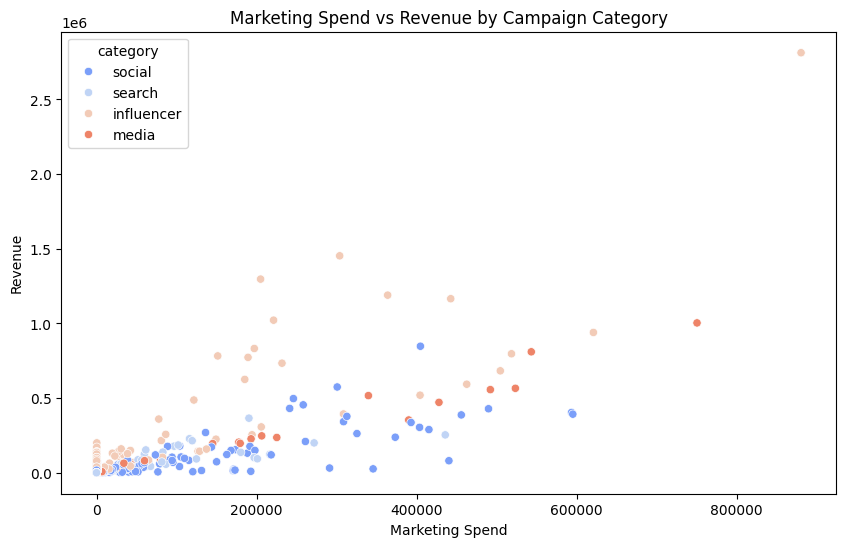

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Marketing Spend vs Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cost', y='revenue', data=df_combined, hue='category', palette='coolwarm')
plt.title('Marketing Spend vs Revenue by Campaign Category')
plt.xlabel('Marketing Spend')
plt.ylabel('Revenue')
plt.show()

The data reveals a clear upward trend in `Marketing Spend` relative to `Revenue`. This indicates a linear relationship between `Marketing Spend` and the `Revenue` generated by each marketing campaign.

A linear relationship suggests that businesses could potentially scale their marketing efforts to achieve proportional increases in revenue. This scalability provides a framework for growth strategies, allowing organizations to predict revenue increases based on planned marketing expenditures.

### 4.2 Campaign Performance: Clicks, Leads, Orders
Analyzing the relationships between clicks, leads, and orders provides insights into the progression of customer engagement through the marketing funnel.

<Figure size 1000x600 with 0 Axes>

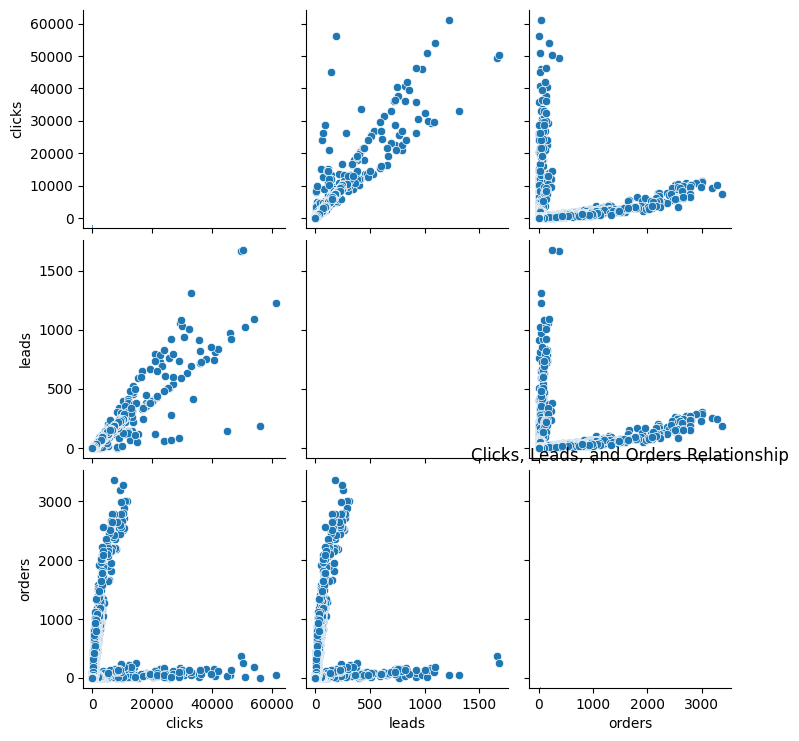

In [6]:
metrics = ['clicks', 'leads', 'orders']

plt.figure(figsize=(10, 6))
sns.pairplot(df_combined[metrics])
plt.title('Clicks, Leads, and Orders Relationship')
plt.show()

Relationship between `clicks`, `leads` and `orders`:

**Clicks and Leads**: There is a clear positive correlation between clicks and leads. As the number of clicks increases, the number of leads tends to increase as well. This trend suggests that higher user engagement (in the form of clicks) may result in more leads.

**Clicks and Orders**: There is also a positive correlation between clicks and orders, though the relationship appears less linear than between clicks and leads. Most orders seem to cluster at lower click counts, with some higher click counts resulting in a small number of orders. This suggests that while clicks can drive orders, the relationship is not as strong or direct, possibly indicating other factors (like lead quality) play a role.

**Leads and Orders**: There is a positive relationship between leads and orders, indicating that more leads tend to yield more orders. However, like with clicks and orders, there is some scatter, suggesting variability in lead conversion rates across campaigns.

**Skewed Distributions**: Each variable (clicks, leads, orders) seems to be right-skewed, with most campaigns generating relatively low counts and a few campaigns resulting in high values. This could indicate that a small number of campaigns drive most of the engagement and conversions.

### 4.3 Revenue by Category

Next, we examine the distribution of revenue across each campaign category. This helps to understand which types of campaigns are generating higher revenue on average.

/var/folders/zw/3t7l5c4d55s8jj_c6q8c681h0000gn/T/ipykernel_10700/4031423155.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_combined, x='category', y='revenue', palette='Set3')


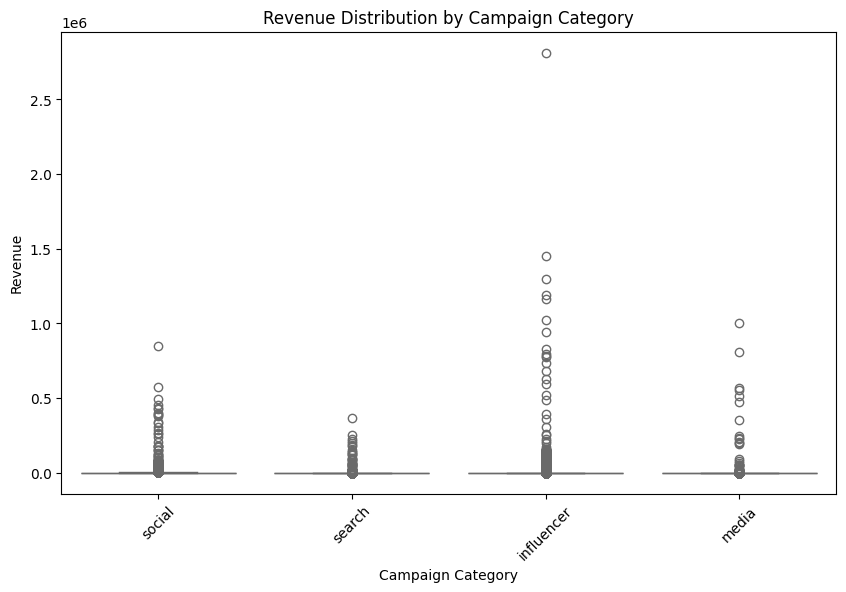

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='category', y='revenue', palette='Set3')
plt.title('Revenue Distribution by Campaign Category')
plt.xlabel('Campaign Category')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

This box plot visualizes the distribution of revenue across four different types of campaign categories: `social`, `search`, `influencer`, and `media`. The plot provides insights into the variability and outliers in revenue generated by each category.

**Key Observations**

1. **Consistent Low Revenue Across Categories**:
   - For all categories, most of the campaigns generate relatively low revenue. This is indicated by the dense clustering of data points near the bottom of each box plot.
   - The boxes themselves are relatively small, which suggests that a large proportion of campaigns within each category generate similar, low levels of revenue.

2. **Presence of Outliers**:
   - Each campaign category has significant outliers, representing campaigns that generated unusually high revenue compared to the majority.
   - Notably, **influencer** campaigns have a particularly high outlier, exceeding 2 million in revenue, which is much higher than outliers in other categories.

3. **Influencer Campaigns Have the Highest Outlier**:
   - While all categories have some high-revenue campaigns, the **influencer** category stands out with the highest revenue outlier. This suggests that influencer campaigns, although not consistently generating high revenue, have the potential to produce exceptionally successful outcomes.

4. **Revenue Range Similarity Across Categories**:
   - Despite the presence of high outliers, the core revenue range (where most campaigns fall) appears to be quite similar across all categories, with limited differences in the interquartile ranges (IQR). This implies that on average, the revenue potential for each category may not be drastically different, although specific campaigns (outliers) can achieve outstanding results.

**Implications**

- The distribution indicates that while most campaigns produce modest revenue, specific high-performing campaigns, particularly in the influencer category, can drive significant revenue. 
- This could suggest that while influencer campaigns are more variable and may involve higher risk, they also offer a greater chance of high returns.

This revenue distribution analysis provides insights into the relative performance and variability of revenue across different campaign categories. **Influencer campaigns** show the highest potential for exceptional revenue, though this comes with variability. Overall, the findings could help guide decisions on where to focus marketing efforts to maximize revenue potential.

### 4.4 Marketing Spend Distribution
We analyze the distribution of marketing spend to understand its overall pattern and identify any outliers or trends that could influence campaign performance. Analyzing the distribution of marketing spend reveals how resources are allocated across campaigns, identifying potential budget inefficiencies or outliers that might be pulling down overall ROI.

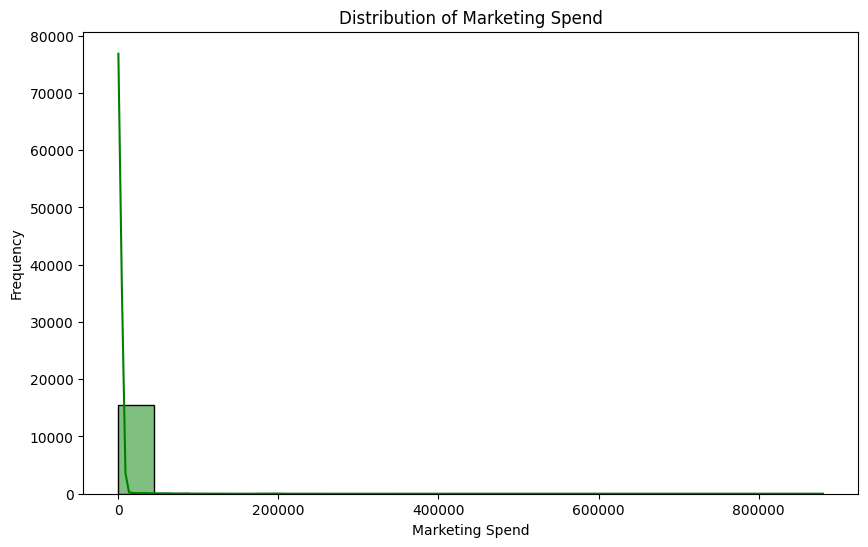

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['cost'], bins=20, kde=True, color='green')
plt.title('Distribution of Marketing Spend')
plt.xlabel('Marketing Spend')
plt.ylabel('Frequency')
plt.show()

This histogram illustrates the distribution of marketing spend across different campaigns. The data shows how frequently each range of marketing spend occurs, revealing key insights about spending patterns.

**Key Observations**

1. **Highly Right-Skewed Distribution**:
   - The distribution is heavily right-skewed, with a majority of campaigns having low marketing spend.
   - Most data points are concentrated in the lower range, with spending clustered near the lower end of the axis, indicating that the majority of campaigns have minimal expenditure.

2. **Long Tail of High-Spend Outliers**:
   - There is a long tail extending to very high marketing spend amounts, though these instances are rare.
   - A few campaigns exhibit very high marketing spend, reaching values up to around 800,000. These high-spend campaigns are outliers compared to the majority, which have much lower spending.

3. **Low Frequency of High Spending**:
   - Campaigns with high marketing spend are infrequent, as indicated by the small number of data points beyond the initial concentration at low spend levels.
   - This suggests that only a few campaigns invest substantial amounts, while most operate on a relatively low budget.

**Implications**

- **Budget Allocation Strategy**:
   - The skewed nature of this distribution could reflect a strategy where most campaigns are low-cost, with occasional high-investment campaigns potentially targeting high-value or strategic objectives.
   - The high-spend campaigns might be aimed at maximizing impact or achieving specific goals, which justifies the higher investment.

The distribution of marketing spend indicates a pattern where most campaigns operate with minimal expenditure, while a small number of campaigns have exceptionally high budgets. This could reflect a deliberate strategy of balancing low-cost campaigns with occasional high-investment efforts. Analyzing the effectiveness of high-spend campaigns versus low-spend campaigns can provide further insights into optimizing marketing budget allocation.



### 4.5 Click to Revenue Conversion Rate
To understand the effectiveness of our marketing campaigns in generating revenue, we first analyze the **Click to Revenue Conversion Rate**. This metric indicates how efficiently clicks on marketing materials convert into revenue.

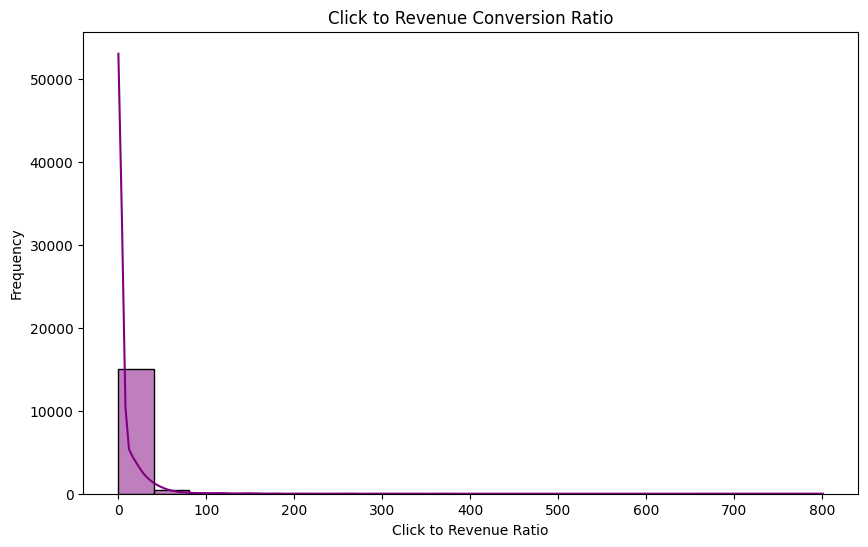

In [9]:
# Plot Click to Revenue Ratio
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['click_to_revenue_ratio'].dropna(), bins=20, kde=True, color='purple')
plt.title('Click to Revenue Conversion Ratio')
plt.xlabel('Click to Revenue Ratio')
plt.ylabel('Frequency')
plt.show()

The histogram of the *Click to Revenue Conversion Ratio* across various marketing campaigns provides key insights into campaign performance.

1. **Highly Skewed Distribution**

The data shows an extremely right-skewed distribution, with the majority of campaigns concentrated at a low Click to Revenue Conversion Ratio. This suggests that:
- Most campaigns generate relatively low revenue per click.
- Possible reasons could be ineffective targeting, low-quality traffic, or a misalignment between ad content and the interests of the audience.

2. **High-Frequency Low Conversion**

A large number of campaigns have a conversion ratio clustered near zero, indicating that many clicks are not translating into revenue.

3. **Outliers in Conversion Ratio**

Some campaigns show significantly higher conversion ratios, extending far along the x-axis. These outliers represent successful campaigns that efficiently convert clicks to revenue.

By analyzing the high-performing and low-performing campaigns, it's possible to better allocate marketing resources and potentially increase the overall return on investment (ROI) for future campaigns.


### 4.6 Revenue vs Leads
Next, we explore the relationship between `Leads` generated and the resulting `Revenue` by their respective `Category`. This analysis helps us understand how effectively leads are converting into revenue across different categories marketing campaigns.

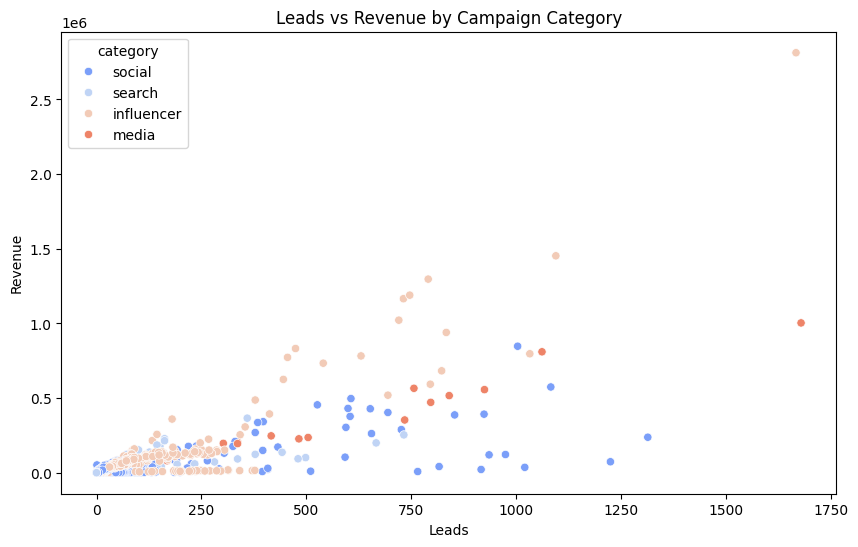

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='leads', y='revenue', data=df_combined, hue='category', palette='coolwarm')
plt.title('Leads vs Revenue by Campaign Category')
plt.xlabel('Leads')
plt.ylabel('Revenue')
plt.show()

This scatter plot visualizes the relationship between `Leads` and `Revenue` for different `Campaign Categories`, including `social`, `search`, `influencer`, and `media`.

1. **Positive Correlation Between Leads and Revenue**

There is a general positive trend, with higher lead counts associated with higher revenue across all campaign categories. This suggests that as campaigns generate more leads, they tend to produce more revenue, reflecting effective lead-to-revenue conversion.

2. **Influencer Campaigns Tend to Generate Higher Revenue**

Campaigns categorized under `influencer` (shown in light orange) appear to have some of the highest revenue values among all categories. Notably, a few `influencer` campaigns reach revenue levels close to 1.5 million, with one even exceeding 2.5 million. This indicates that influencer campaigns may be particularly successful in generating substantial revenue, possibly due to wider reach or better alignment with the target audience.

3. **Variability in Campaign Effectiveness**

There is notable variability in revenue for a similar number of leads across different categories:
   - For example, `social` campaigns (in blue) with around 500 leads show a spread in revenue, ranging from low to moderate amounts.
   - Similarly, `media` campaigns (in red) show a moderate range of revenue, but with relatively fewer high-revenue outliers compared to *media* campaigns.

4. Search Campaigns Underperforming in Revenue

`Search` campaigns (in light blue) appear to cluster toward lower revenue amounts, even when lead counts are higher. This might imply that search campaigns are less efficient in converting leads into revenue compared to other types, potentially due to lower engagement or targeting issues.

In summary, this plot highlights the generally positive relationship between leads and revenue, with **Influencer** campaigns standing out as high-performers.


## 5. Modelling

### 5.1 Rationale for using Random Forest Regressor for ROI Model

In this ROI model, we aim to predict *clicks*, *leads*, and *orders* based on the *category of campaign* and the *cost* (or budget) allocated to each campaign. Here’s why the **Random Forest Regressor** was chosen and how it supports the model requirements:

#### 5.1.1 Handling Both Categorical and Numerical Inputs
The model’s input features include:
   - **Category**: a categorical variable representing the type of campaign (e.g., *social*, *search*, *influencer*, *media*).
   - **Cost**: a numerical variable indicating the campaign budget.

The use of one-hot encoding allows us to convert the categorical *category* variable into a format compatible with Random Forest. By encoding *category* and keeping *cost* as is, we ensure the model can process both types of data effectively.

#### 5.1.2 Ability to Handle Non-Linear Relationships
Random Forest models are well-suited for capturing non-linear relationships, which are often present in marketing data:
   - The relationship between *cost* and the output metrics (*clicks*, *leads*, *orders*) is not always linear. For instance, increasing the budget doesn’t necessarily lead to proportional increases in leads or orders due to factors like diminishing returns.
   - Campaign category effects are likely non-linear as well, with some categories potentially yielding higher conversion rates for specific budget ranges.

Random Forest’s ability to model these complex interactions is advantageous for predicting ROI accurately.

#### 5.1.3 Multi-Output Regression Capability
In this model, the targets are three separate outputs: *clicks*, *leads*, and *orders*. Using a multi-output Random Forest Regressor allows the model to predict these three interrelated metrics simultaneously. This approach leverages the fact that certain relationships among *clicks*, *leads*, and *orders* may improve prediction accuracy. For instance, campaigns generating high clicks may also see a proportional increase in leads, which is useful for the model to capture.

#### 5.1.4 Robustness and Interpretability
Random Forest models provide stability by averaging predictions across multiple decision trees (in this case, 100 trees). This ensemble approach:
   - **Reduces Overfitting**: By averaging the predictions of multiple trees, Random Forest mitigates overfitting, which is important for generalizing predictions across varying campaign data.
   - **Enhances Model Interpretability**: Feature importance metrics from Random Forest can help in understanding which features (e.g., certain campaign categories or cost ranges) are more influential in driving the outputs.

### 5.2 Evaluation Metrics
For this model, we use **Mean Squared Error (MSE)** and **R² score** to evaluate prediction accuracy for each target variable:
   - **MSE** provides insight into the average squared error, allowing us to gauge how well the model fits on average for each target.
   - **R² score** measures the proportion of variance explained by the model, indicating how well each target variable (clicks, leads, and orders) is predicted relative to its variability.


In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Assume df is your already available dataset
# Selecting features (category and cost) and targets (clicks, leads, orders)
X = df_combined[['category', 'cost']]  # Input features: category (categorical) and cost (numerical)
y = df_combined[['clicks', 'leads', 'orders']]  # Targets: clicks, leads, orders (all numerical)

# One-hot encoding for 'category'
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X[['category']])

# Concatenate the encoded category with cost
X_transformed = np.concatenate([X_encoded, X[['cost']].values], axis=1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Define and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error and R^2 score for each target
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print the accuracy for each target variable
target_names = ['clicks', 'leads', 'orders']
for i, target in enumerate(target_names):
    print(f"{target} - MSE: {mse[i]}, R^2: {r2[i]}")

# ===========================
# Generating a Synthetic Dataset for Testing
# ===========================

# Categories for the synthetic data
categories = ['influencer', 'social', 'search', 'media']
n_samples = 100  # Number of synthetic data points

# Generating random synthetic data
synthetic_data = pd.DataFrame({
    'category': np.random.choice(categories, size=n_samples),
    'cost': np.random.uniform(100, 5000, size=n_samples)  # Random cost values
})

# One-hot encode the synthetic categories
synthetic_encoded = encoder.transform(synthetic_data[['category']])

# Concatenate the encoded categories with synthetic cost
X_synthetic = np.concatenate([synthetic_encoded, synthetic_data[['cost']].values], axis=1)

# Predict the target variables on synthetic data
y_synthetic_pred = model.predict(X_synthetic)

# Display the synthetic data and corresponding predictions
synthetic_data['clicks'] = y_synthetic_pred[:, 0]
synthetic_data['leads'] = y_synthetic_pred[:, 1]
synthetic_data['orders'] = y_synthetic_pred[:, 2]

# Show synthetic dataset with predictions
print(synthetic_data)

clicks - MSE: 1056859.7737488123, R^2: 0.7518995725565324
leads - MSE: 778.8195481341564, R^2: 0.7512478467799721
orders - MSE: 9636.493637173668, R^2: 0.786520984478404
      category         cost    clicks   leads   orders
0       social   704.905784   1459.16   23.39   570.55
1   influencer  2667.493709   1508.38   35.80   299.00
2        media   672.706438   1664.33   16.20   374.10
3       search  3496.264868   1164.91   21.09     0.98
4   influencer  4701.249915   1433.40   31.77   217.49
..         ...          ...       ...     ...      ...
95       media  1802.778973    453.44    5.53     0.46
96  influencer  1403.999527  10253.64  256.32  2610.84
97       media  3032.490731    623.10    4.97     0.56
98  influencer  3807.199803   1502.38   35.81   299.00
99      social   905.974467   1120.89    7.63   112.84

[100 rows x 5 columns]


## 6. Model with Improved Relational Data

### 6.1 Introducing Regressor Chain

In this updated model, we chose to implement a **Regressor Chain** on top of a **Random Forest Regressor**. This approach allows us to leverage the relationships between the three output variables: *clicks*, *leads*, and *orders*. 

Our method is to use the predicted clicks as an input to predict leads, and then use both clicks and leads to predict orders.

### 6.2 Advantages of Using Regressor Chain

The output variables—*clicks*, *leads*, and *orders*—are likely interdependent:
   - **Clicks** often lead to **leads**, as a higher number of clicks increases the chance of conversions.
   - Similarly, **leads** contribute to **orders** since more qualified leads can generate more sales.

By using a Regressor Chain, we can model this sequential dependency by making predictions in a specified order (in this case, *clicks* → *leads* → *orders*). This chaining approach allows each target prediction to consider the previously predicted target values, enhancing accuracy by factoring in the natural progression from clicks to orders.

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import RegressorChain

# Assume df_combined is your dataset with features and targets already defined
# Selecting features (category and cost) and targets (clicks, leads, orders)
X = df_combined[['category', 'cost']]  # Input features
y = df_combined[['clicks', 'leads', 'orders']]  # Targets

# One-hot encoding for the 'category' column
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X[['category']])

# Concatenate the encoded category with the cost column
X_transformed = np.concatenate([X_encoded, X[['cost']].values], axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Define the base model and RegressorChain for chained multi-output regression
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = RegressorChain(base_model, order=[0, 1, 2])  # Predict clicks, then leads, then orders

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error and R^2 score for each target
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print the accuracy for each target variable
target_names = ['clicks', 'leads', 'orders']
for i, target in enumerate(target_names):
    print(f"{target} - MSE: {mse[i]}, R^2: {r2[i]}")


clicks - MSE: 1050362.933327281, R^2: 0.7534247218011634
leads - MSE: 737.1069870229009, R^2: 0.7645706882746485
orders - MSE: 10855.29477037217, R^2: 0.7595206588591227


### 6.3 Implementation of the Regressor Chain
In the code, we defined a **RegressorChain** with the following parameters:
   - **Base Model**: `RandomForestRegressor(n_estimators=100, random_state=42)`, which provides stable and accurate predictions at each step.
   - **Order**: `[0, 1, 2]`, specifying that predictions should follow the sequence of *clicks*, then *leads*, and finally *orders*.

The `RegressorChain` model fits in a sequential manner:
   - The first model predicts *clicks* based on the input features.
   - The second model predicts *leads* using both the input features and the previously predicted *clicks* values.
   - The third model predicts *orders* using the input features as well as the predicted *clicks* and *leads* values.

This chaining process enables each prediction to consider the preceding target predictions, thus embedding interdependencies among the output variables.

### 6.4 Evaluation Metrics
As with the previous model, we evaluate the chained model using **Mean Squared Error (MSE)** and **R² score** for each target variable. These metrics provide a detailed look at the performance of each stage in the chain, allowing us to assess:
   - **Accuracy of each target prediction** individually.
   - **Effectiveness of the chaining approach** in reducing error and improving the explanatory power of the model.

In conclusion, adding a Regressor Chain to our model builds on the strengths of the Random Forest Regressor while incorporating interdependencies among outputs. This approach better represents the flow of conversions in a marketing campaign, potentially resulting in more accurate and interpretable ROI predictions.

## 7. Comparison of Model Performance: Independent Random Forest vs. Regressor Chain

We conducted a comparison between two approaches to model our ROI data: the **independent Random Forest Regressor** and the **Random Forest Regressor with a Regressor Chain**. Here’s a summary of the results and observations for each output variable—*clicks*, *leads*, and *orders*.

### Results Summary

| Metric       | Without Regressor Chain | With Regressor Chain |
|--------------|--------------------------|-----------------------|
| **Clicks - MSE**   | 1,056,859.77               | 1,050,362.93          |
| **Clicks - R²**    | 0.7519                     | 0.7534                |
| **Leads - MSE**    | 778.82                     | 737.11                |
| **Leads - R²**     | 0.7512                     | 0.7646                |
| **Orders - MSE**   | 9,636.49                   | 10,855.29             |
| **Orders - R²**    | 0.7865                     | 0.7595                |

### Observations

1. **Clicks**:
   - **Mean Squared Error (MSE)**: The chain model shows a slight improvement in MSE for *clicks* (from 1,056,859.77 to 1,050,362.93).
   - **R² Score**: The R² score also improved slightly from 0.7519 to 0.7534, indicating a small increase in the model’s ability to explain the variance in clicks.
   - **Interpretation**: The chain model does not substantially improve *clicks*, possibly because clicks are the first target in the chain and thus are less influenced by other target variables.

2. **Leads**:
   - **MSE**: For *leads*, the chain model notably reduces the error (from 778.82 to 737.11).
   - **R² Score**: There’s a noticeable improvement in R² from 0.7512 to 0.7646, suggesting that the chain model better captures the variance in leads.
   - **Interpretation**: The chained model benefits *leads* predictions as it uses the predicted *clicks* values, aligning with the logical flow that more clicks often lead to more leads. This interdependency is effectively leveraged in the chained approach.

3. **Orders**:
   - **MSE**: The MSE for *orders* is slightly higher in the chained model (from 9,636.49 to 10,855.29).
   - **R² Score**: The R² decreases from 0.7865 to 0.7595, indicating a slight decline in the model’s performance for orders.
   - **Interpretation**: The chained approach did not improve *orders* predictions, likely because the propagation of errors from *clicks* and *leads* impacted the final target. Since orders depend indirectly on *clicks* and *leads*, this model might introduce additional variability at this final stage.

### Key Takeaways

- **Improvement in Leads Prediction**: The Regressor Chain approach improves the predictions for *leads* significantly, which makes sense given the natural conversion path from clicks to leads.
- **Trade-off for Orders Prediction**: The minor increase in error for *orders* highlights the challenge in chaining multiple stages, as errors can propagate and amplify across the targets.
- **Overall Balance**: While the Regressor Chain improves intermediate stages (leads), it slightly compromises the final target (orders). Depending on priorities—whether accuracy for each target independently or capturing interdependencies is more important—either model could be preferred.

### Conclusion
The Regressor Chain model leverages interdependencies between outputs, improving the prediction of intermediate outcomes like *leads*. However, it comes with a slight trade-off for *orders* accuracy due to error propagation. This trade-off might be acceptable depending on the importance of accurately modeling these interdependencies, especially if capturing the conversion funnel flow is a primary objective.
